# Create Data Set
# A* search algorithm

In [11]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
ox.settings.log_console=True
ox.__version__

'1.2.2'

# Extract

* Define source_geocode
* Get the graph from that location
* Get GeoPandas GeoDataFrames from the graph

Using OMSnx to extarct an geocode from SomeLocation and then, expand a graph from that location.<br>
Once you have the Streets in a graph design, you can convert it to an UnidirectedGraph and to a Geopandas dataframe.

## Define source geocode

In [3]:
# Geocode a query string to (lat, lng) with the Nominatim geocoder.

empire_state_address = "Praça Franklin Roosevelt, Brasil"
graph_source_geocode=ox.geocoder.geocode(empire_state_address)
graph_source_geocode

(-23.54869465, -46.64678129316892)

### graph_from_point()

In [4]:
# get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want

networkRange = 3000  # meters
G = ox.graph_from_point(graph_source_geocode, dist=networkRange, network_type="drive")

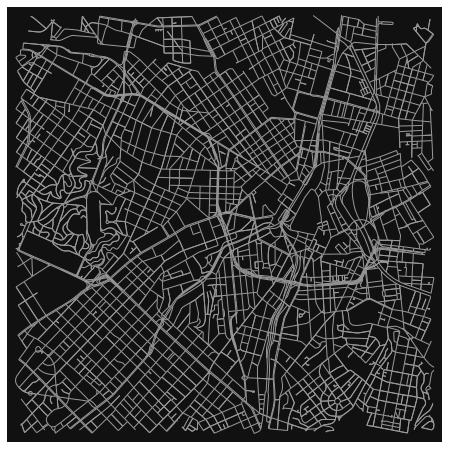

In [5]:
fig, ax = ox.plot_graph(G, node_size=0)

In [6]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

In [7]:
#Save graph on disk, therefore we can access it later
path="bigScale_DataSet/graph/"

ox.save_graphml(G, path+'my_graph')

In [8]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(M)

In [12]:
empire_state_address = "Mercado Municipal de São Paulo"
source_geocode=ox.geocoder.geocode(empire_state_address)
source_geocode

(-23.54173325, -46.629524373800876)

In [13]:
# Within M network get node nearest from Lat and Lng
source_node = ox.distance.nearest_nodes(G, Y=source_geocode[0], X=source_geocode[1])
source_node

4509509557

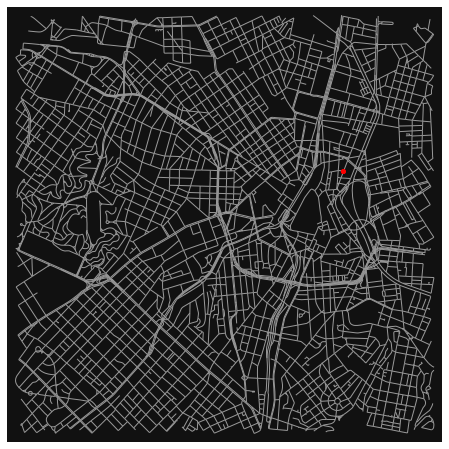

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [14]:
ox.plot_graph_route(M, [source_node],
                    node_size=0, edge_linewidth=1,
                    route_linewidth=2, route_alpha=1,
                    orig_dest_size=25)

# Transform

* Define Heuristic
* Apply Heuristic to the Dataset
* Filter not needed columns

##### Define Target Node

In [16]:
# Geocode a query string to (lat, lng) with the Nominatim geocoder.

times_square_address="Museu do Futebol, Praça Charles Miller, Brasil"
target_geocode=ox.geocoder.geocode(times_square_address)

# Within M network get node nearest from Lat and Lng
target_node = ox.distance.nearest_nodes(G, Y=target_geocode[0], X=target_geocode[1])
target_node

4640179392

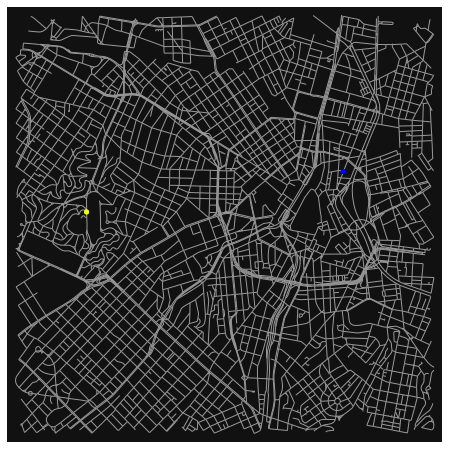

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [17]:
ox.plot_graph_routes(M, [[target_node], [source_node]],
                    node_size=0, edge_linewidth=1,
                    route_linewidth=2, route_alpha=1,
                    orig_dest_size=25, route_colors=["#F0FF00", "b"])

## Add Heurist 

In order to use an **A* Algorithm** you need to have an acceptable **Heuristic**. <br>
In this case we are enhancing the DataSet with the Greate-Circle distance. This is our heuristic. <br>

In [21]:
# Iterate over gdf_nodes and calculate to each node its gc_distance to target_node
# Greate-Circle distance is our heuristic

dest=gdf_nodes.loc[target_node,["y","x"]]

for index,row in gdf_nodes.iterrows():
    
    current=gdf_nodes.loc[index,["y","x"]]
    
    gc_distance=ox.distance.great_circle_vec(current["y"], current["x"], dest["y"], dest["x"])
    
    gdf_nodes.loc[index,("gc_distance")]=gc_distance

In [22]:
#In order to see the Heuristic applied to the Dataframe in a visual way.
#With the nodes gc_distancein hands, calculates the edges gc_distance

edges_gcd={}

for index,row in gdf_edges[["from","to"]].iterrows():
    
    from_gcd=gdf_nodes.loc[row["from"],("gc_distance")]
    to_gcd=gdf_nodes.loc[row["to"],("gc_distance")]
   
    edges_gcd[index]=(-1)*((from_gcd+to_gcd)/2)
    
nx.set_edge_attributes(M, edges_gcd, "edge_gcd")

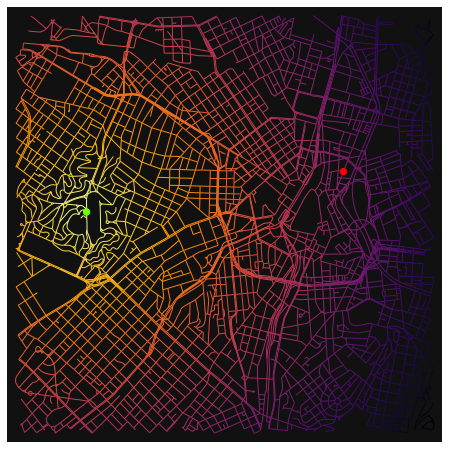

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [25]:
# color edges in original graph with Great-Circle Distance from line graph

ec = ox.plot.get_edge_colors_by_attr(M, "edge_gcd", cmap="inferno")

ox.plot_graph_routes(M, [[target_node], [source_node]],
                    node_size=0, edge_linewidth=1,
                    route_linewidth=2, route_alpha=1,
                    orig_dest_size=50, route_colors=["#6CFF00", "r"],
                    edge_color=ec)

## Filter for only Needed Columns
Defining problem scope and selecting only valid columns<br>
<br>
As the OSMnx package provide us many geospatial data when we querying for the graph, now we filtering for olny the columns that are needed for support the **A* Algorithm**


### Filter on Nodes dataframe
With heuristic "gc_distance"

f(x)=g(x)+__h(x)__

In [26]:
gdf_nodes_final = gdf_nodes[["gc_distance"]].copy()

gdf_nodes_final=gdf_nodes_final.reset_index()
gdf_nodes_final=gdf_nodes_final.rename(columns={"osmid": "node_id"})
gdf_nodes_final=gdf_nodes_final.set_index(["node_id"])

In [27]:
#Check Integrity of data after transformations
macth_count=0
for i,r in gdf_nodes.iterrows():
    original_gcd=gdf_nodes.loc[i]["gc_distance"]
    new_gcd=gdf_nodes_final.loc[i]["gc_distance"]
    
    if(original_gcd!=new_gcd):
        print("error")
    else:
        macth_count=macth_count+1 
print("Node matches: "+str(macth_count)+"/"+str(len(gdf_nodes)))

Node matches: 3869/3869


### Filter on Edges dataframe

With cost_function "length"

f(x)=__g(x)__+h(x)

In [28]:
gdf_edges_final=gdf_edges[["osmid","from","to","length"]].copy()

gdf_edges_final=gdf_edges_final.rename(columns={"osmid": "edge_id"})

In [29]:
#Check Integrity of data after transformations
macth_count=0
for i,r in gdf_edges.iterrows():
    original_eid=gdf_edges.loc[i]["osmid"]
    new_eid=gdf_edges_final.loc[i]["edge_id"]
    
    if(original_eid!=new_eid):
        print("error")
    else:
        macth_count=macth_count+1
print("Edge matches: "+str(macth_count)+"/"+str(len(gdf_edges)))

Edge matches: 6062/6062


# Load

* Saving data as .csv<br>
* Reload it and check for dataIntegrity

### Nodes

In [30]:
path="bigScale_DataSet/geoPandas_dataFrame/"

gdf_nodes_final.to_csv(path+'gdf_nodes_final.csv',index = True)

gdf_nodes_read = pd.read_csv(path+'gdf_nodes_final.csv',index_col=["node_id"],float_precision='round_trip')

In [31]:
#Check Integrity of data after transformations
macth_count=0
for i,r in gdf_nodes.iterrows():
    original_gcd=gdf_nodes.loc[i]["gc_distance"]
    saved_gcd=gdf_nodes_read.loc[i]["gc_distance"]
    
    if(original_gcd!=saved_gcd):
        print("original_gcd:"+str(original_gcd))
        print("saved_gcd:"+str(saved_gcd))
        print("error")
    else:
        macth_count=macth_count+1
print("Node matches: "+str(macth_count)+"/"+str(len(gdf_nodes)))

Node matches: 3869/3869


### Edges

In [32]:
path="bigScale_DataSet/geoPandas_dataFrame/"

gdf_edges_final.to_csv(path+'gdf_edges_final.csv',index = True)

gdf_edges_read = pd.read_csv(path+'gdf_edges_final.csv',index_col=["u","v","key"])

In [33]:
#Check Integrity of data after transformations
macth_count=0
for i,r in gdf_edges.iterrows():

    original_eid=gdf_edges.loc[i]["osmid"]
    saved_eid=gdf_edges_read.loc[i]["edge_id"]
    
    if(str(original_eid)!=str(saved_eid)):
        print("original_eid:"+str(original_eid))
        print("saved_eid:"+str(saved_eid))
        print("original_eid:"+str(type(original_eid)))
        print("saved_eid:"+str(type(saved_eid)))
        
        print("error")
    else:
        macth_count=macth_count+1
print("Edge matches: "+str(macth_count)+"/"+str(len(gdf_edges)))

Edge matches: 6062/6062
